In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
def get_data():
    months=['02','03','04','05','06']
    data=pd.read_csv('C:/Users/U6080396/Desktop/Projects/Yellow taxi/yellow_tripdata_2018-01.csv')
    for m in months:
            update=pd.read_csv('C:/Users/U6080396/Desktop/Projects/Yellow taxi/yellow_tripdata_2018-{}.csv'.format(m))
            data=pd.concat([data,update])
    return data

In [3]:
data=get_data()

In [4]:
def iqr_fence(x):
    q3=np.percentile(x,75)
    q1=np.percentile(x,25)
    iqr=q3-q1
    upper_fence=q3+3*iqr
    lower_fence=q1-3*iqr
    return lower_fence,upper_fence

In [5]:
#Czyszczenie danych
#Usunięcie nic nie wnoszących kolumn
data=data.drop(['fare_amount'], axis=1) #Silnie skorelowane z total_amount
data=data.drop(['improvement_surcharge'], axis=1) # W znacznej wielkości przypadków przyjmuje wartość 0.3
data=data.drop(['tolls_amount'], axis=1) # W 99.7% przypadków opłaty drogowe wynoszą zero
data=data.drop(['mta_tax'], axis=1) # W 99.9 % ten podatek wynosi 0.5
#Zmiana typu zmiennych czasowych na datetime
data['tpep_pickup_datetime']=pd.to_datetime(data['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
data['tpep_dropoff_datetime']=pd.to_datetime(data['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
#Określenie zmiennych kategorycznych
data['VendorID']=data['VendorID'].astype('category')
data['RatecodeID']=data['RatecodeID'].astype('category')
data['store_and_fwd_flag']=data['store_and_fwd_flag'].astype('category')
data['payment_type']=data['payment_type'].astype('category')
data['PULocationID']=data['PULocationID'].astype('category')
data['DOLocationID']=data['DOLocationID'].astype('category')
#Usunięcie podejrzanych wartości oraz wartości odstających (odrzuciłem wartości które nie mieszczą sie w powiększonym siedmiokrotnie rozstepie ćwiartkowym)
data=data[data["RatecodeID"]!=99]
data=data[data["VendorID"]!=4]
data=data[data['total_amount']<iqr_fence(data['total_amount'])[1]]
data=data[data['total_amount']>0]
data=data[data['passenger_count']<iqr_fence(data['passenger_count'])[1]]
data=data[data['passenger_count']>0]
data=data[data['trip_distance']<iqr_fence(data['trip_distance'])[1]]
data=data[data['trip_distance']>-0.0001]
data=data[data['tip_amount']<iqr_fence(data['tip_amount'])[1]]
data=data[data['tip_amount']>-0.0001]
data=data[data['extra']<iqr_fence(data['extra'])[1]]
data=data[data['extra']>-0.0001]

In [ ]:
def get_results(model):
    history=model.fit(X_train, y_train)
    predictions_train=model.predict(X_train)
    predictions_test=model.predict(X_test)
    mse_train=mean_squared_error(predictions_train,y_train)
    mse_test=mean_squared_error(predictions_test,y_test)
    print('Train MSE:',mse_train,', Test MSE:',mse_test)

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


In [5]:
data.shape

(53925735, 17)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45047369 entries, 0 to 8713829
Data columns (total 13 columns):
VendorID                 category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
RatecodeID               category
store_and_fwd_flag       category
PULocationID             category
DOLocationID             category
payment_type             category
extra                    float64
tip_amount               float64
total_amount             float64
dtypes: category(6), datetime64[ns](2), float64(4), int64(1)
memory usage: 3.0 GB


In [45]:
data.corr()

,passenger_count,trip_distance,extra,tip_amount,total_amount
passenger_count,1.000000,0.017013,0.020523,-0.015451,0.013793
trip_distance,0.017013,1.000000,0.041810,0.434477,0.893086
extra,0.020523,0.041810,1.000000,0.057818,0.084568
tip_amount,-0.015451,0.434477,0.057818,1.000000,0.638705
total_amount,0.013793,0.893086,0.084568,0.638705,1.000000


In [21]:
#Nie ma braków danych
data.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
total_amount             0
dtype: int64

In [10]:
data.describe()

,passenger_count,trip_distance,extra,mta_tax,tip_amount,tolls_amount,total_amount
count,5.392279e+07,5.392279e+07,5.392279e+07,5.392279e+07,5.392279e+07,5.392279e+07,5.392279e+07
mean,1.599911e+00,2.900877e+00,3.320255e-01,4.973464e-01,1.866823e+00,3.351460e-01,1.613301e+01
std,1.248154e+00,2.607482e+01,4.619663e-01,4.352552e-02,2.570324e+00,1.798356e+00,7.132924e+01
min,0.000000e+00,0.000000e+00,-6.000000e+01,-5.000000e-01,-3.224200e+02,-5.250000e+01,-4.858000e+02
25%,1.000000e+00,9.600000e-01,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.300000e+00
50%,1.000000e+00,1.600000e+00,0.000000e+00,5.000000e-01,1.400000e+00,0.000000e+00,1.176000e+01
75%,2.000000e+00,3.000000e+00,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,1.730000e+01
max,1.920000e+02,1.894838e+05,9.664000e+01,6.080000e+01,4.960000e+02,1.650000e+03,3.491168e+05


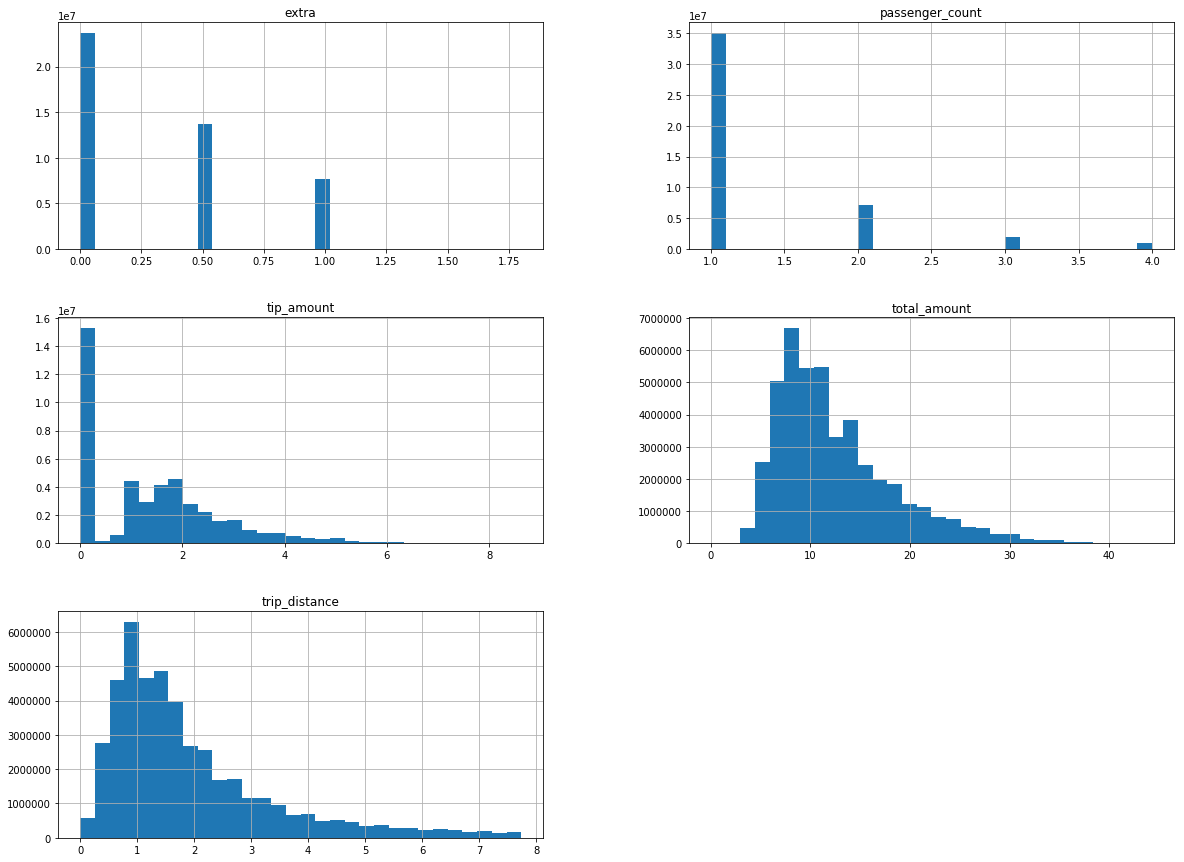

In [9]:
data.hist(bins=30,figsize=(20,15))
plt.show()

In [7]:
sample=data.sample(frac=0.001)

In [7]:
sample.shape

(45047, 13)

C:\Users\U6080396\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\U6080396\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


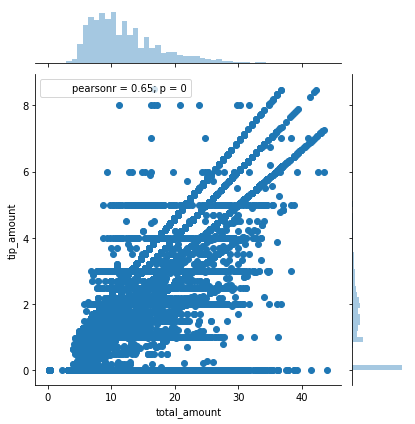

In [8]:
sns.jointplot('total_amount','tip_amount', data=sample)

C:\Users\U6080396\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\U6080396\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


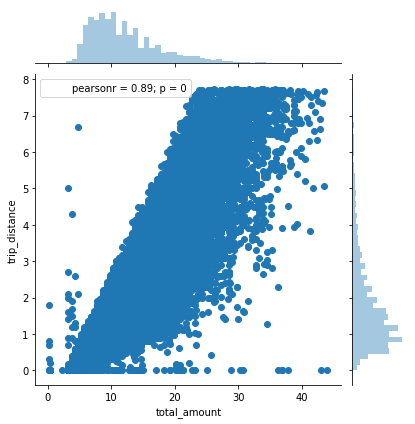

In [9]:
sns.jointplot('total_amount','trip_distance', data=sample)

In [8]:
#Podział na X,Y
sample['tpep_pickup_datetime']=pd.to_timedelta(sample['tpep_pickup_datetime']).dt.total_seconds()
sample['tpep_dropoff_datetime']=pd.to_timedelta(sample['tpep_dropoff_datetime']).dt.total_seconds()
sample['store_and_fwd_flag']=sample['store_and_fwd_flag'].map(dict(Y=1, N=0))
Y=sample['total_amount']
X=sample.loc[:,data.columns!='total_amount']


In [9]:
X.shape,Y.shape

((45047, 12), (45047,))

In [10]:
#Podział na zbiór testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [12]:
lr=LinearRegression()
get_results(lr)

Train MSE: 4.19210169493504 , Test MSE: 4.302183841941481


In [36]:
importance=lr.coef_

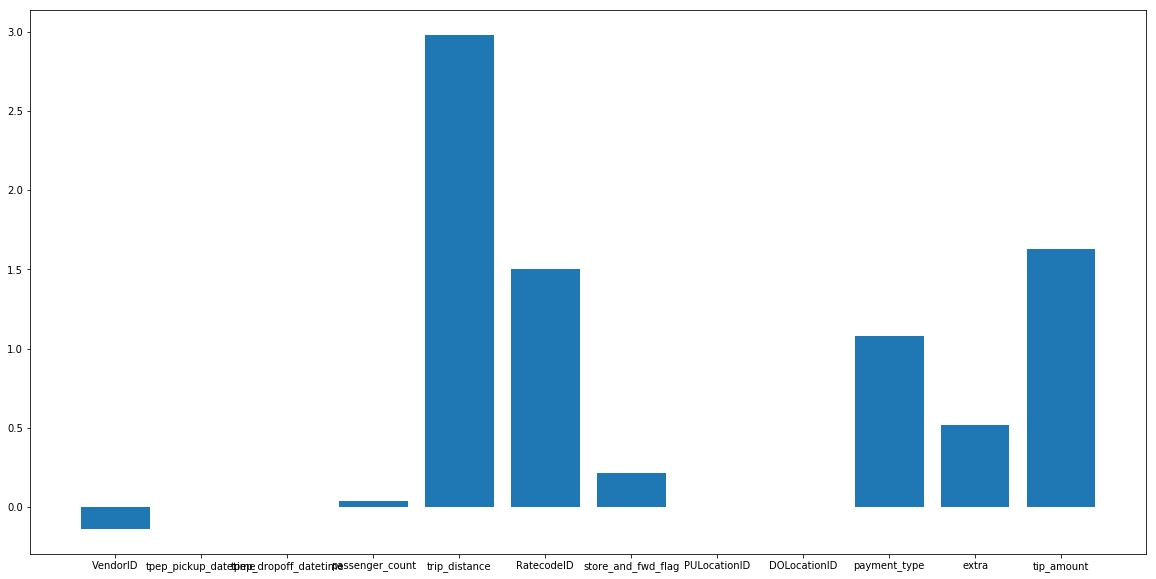

In [44]:
#Wpływ zmiennych na wynik regresji
plt.figure(figsize=(20,10))
plt.bar(X.columns, importance)
plt.show()

In [30]:
#Drzewo losowe
tree=DecisionTreeRegressor(max_depth=7)
get_results(tree)

Train MSE: 3.2790368222301995 , Test MSE: 3.482800208280535


Wnioski:
Nie dałem rady przeanalizować całego zbioru danych. Do tego niezbędna jest znajomość pysparka , a z nim niestety jeszcze nie miałem styczności.

Po redukcji zbioru danych dokonałem analizy, z której wysnułem następujące wnioski. Dane były dość mocno zanieczyszczone, co prawda nie znalazłem braków danych, jednakże wystąpiły wartości odstające w całkiej sporej ilości. W celu eliminacji ich z mojego zbioru zbudowałem funkcję, która odrzuca wartość, jeśli nie znajduje sie ona w siedmiokrotnym odstępię międzykwartalnym. Usunąłem też wartości nie mające sensu (typu 0 pasażerów lub ujemny napiwek).

Po tych zabiegach dało się wreszcie sprawdzić rozkłady zmiennych z tego zbioru za pomocą histogramu. Na pewno nie pochodzą z rozkładu normalnego, możliwy jest rozkład lognormalny. Najbardziej podobne histogramy miały zmienne total_amount oraz trip_distance. Istnieje również silna korelacja pomiędzy tymi zmiennymi. Z wykresu tych zmiennych widać wyraźnie, że jest wyznaczona granica, poniżej której się nie zapłaci przy danym dystansie.

Przeanalizowałem również kilka modeli podchodząc do tego zagadnienia jako problem regresji ze zmienną celu total_amount. Okazało się, że dość łatwo stworzyć model dobrze przybliżający tą wartość. Nawet regresja liniowa dała zadowalające wyniki. Z analizy jej współczynników doszedłem do wniosku, że oprócz dystansu, na cenę końcową maja znaczący wpływ zmienne tip_amount, extra , payment_type oraz RatecodeID. Zaskakujące dla mnie było , że czas początku i zakończenia kursu nie miał znaczącego wpływu na total_amount. W Polsce zazwyczaj jest duża różnica między taryfą dzienną i nocną.

Oczywiście regresja liniowa nie jest najlepszym modelem do tego zagadnienia. Regresor drzewa losowego dał mi lepsze wyniki, z drugiej strony sieci neuronowe nie spisały się najlepiej.